# Overview
- nb006の編集
- ドリフト部分を除いたデータ・セットを取得した
- nb006のデータを入れ替える 

# Const

In [1]:
NB = '007'
isSmallSet = False
LENGTH = 7000

PATH_TRAIN = './../data/input/train_clean.csv'
PATH_TEST = './../data/input/test_clean.csv'
PATH_SMPLE_SUB = './../data/input/sample_submission.csv'
DIR_OUTPUT = './../data/output/'
cp = ['#f8b195', '#f67280', '#c06c84', '#6c5b7b', '#355c7d']
sr = 10*10**3  # 10 kHz

# Import everything I need :)

In [2]:
import warnings
warnings.filterwarnings('ignore')
import time
import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastprogress import progress_bar
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from dtreeviz.trees import dtreeviz

# My function

In [3]:
def f1_macro(true, pred):
    return f1_score(true, pred, average='macro')

def get_df_batch(df, batch):
    idxs = df['batch'] == batch
    assert any(idxs), 'そのようなbatchはありません'
    return df[idxs]
    
def get_signal_mv_mean(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).mean().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

def get_signal_mv_std(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).std().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

def get_signal_mv_min(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).min().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

def get_signal_mv_max(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).max().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

class permutation_importance():
    def __init__(self, model, metric):
        self.is_computed = False
        self.n_feat = 0
        self.base_score = 0
        self.model = model
        self.metric = metric
        self.df_result = []
    
    def compute(self, X_valid, y_valid):
        self.n_feat = len(X_valid.columns)
        if self.metric == 'auc':
            y_valid_score = self.model.predict_proba(X_valid)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
            self.base_score = auc(fpr, tpr)
        else:
            pred = np.round(self.model.predict(X_valid)).astype('int8')
            self.base_score = self.metric(y_valid, pred)
        self.df_result = pd.DataFrame({'feat': X_valid.columns, 
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
        
        # predict
        for i, col in enumerate(X_valid.columns):
            df_perm = X_valid.copy()
            np.random.seed(1)
            df_perm[col] = np.random.permutation(df_perm[col])
            y_valid_pred = self.model.predict(df_perm)
            if self.metric == 'auc':
                y_valid_score = self.model.predict_proba(df_perm)[:, 1]
                fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
                score = auc(fpr, tpr)
            else:
                score = self.metric(y_valid, np.round(y_valid_pred).astype('int8'))
            self.df_result['score'][self.df_result['feat']==col] = score
            self.df_result['score_diff'][self.df_result['feat']==col] = self.base_score - score
        self.is_computed = True
    
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] < 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
        
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] > 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    
    def show_permutation_importance(self, score_type='loss'):
        '''score_type = 'loss' or 'accuracy'  '''
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        if score_type=='loss':
            ascending = True
        elif score_type=='accuracy':
            ascending = False
        else:
            ascending = ''
        
#         plt.figure(figsize=(15, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=ascending))
        plt.title('base_score - permutation_score')

# Preparation

setting

In [4]:
sns.set()

<br>

load dataset

In [5]:
df_tr = pd.read_csv(PATH_TRAIN)
df_te = pd.read_csv(PATH_TEST)

<br>

処理のしやすさのために、バッチ番号を振る

In [6]:
batch_list = []
for n in range(10):
    batchs = np.ones(500000)*n
    batch_list.append(batchs.astype(int))
batch_list = np.hstack(batch_list)
df_tr['batch'] = batch_list

batch_list = []
for n in range(4):
    batchs = np.ones(500000)*n
    batch_list.append(batchs.astype(int))
batch_list = np.hstack(batch_list)
df_te['batch'] = batch_list

<br>

smallset?

In [7]:
if isSmallSet:
    print('small set mode')
    # train
    batchs = df_tr['batch'].values
    dfs = []
    for i_bt, bt in enumerate(df_tr['batch'].unique()):
        idxs = batchs == bt
        _df = df_tr[idxs][:LENGTH].copy()
        dfs.append(_df)
    df_tr = pd.concat(dfs).reset_index(drop=True)
    
    # test
    batchs = df_te['batch'].values
    dfs = []
    for i_bt, bt in enumerate(df_te['batch'].unique()):
        idxs = batchs == bt
        _df = df_te[idxs][:LENGTH].copy()
        dfs.append(_df)
    df_te = pd.concat(dfs).reset_index(drop=True)

# Feature engineering

In [8]:
def get_signal_lag(df, lag=1):
    signal_lag = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
#         _signal_lag = df['signal'][idxs].shift(lag).interpolate('spline', order=5, limit_direction='both').values
        _signal_lag = df['signal'][idxs].shift(lag).interpolate('linear', limit_direction='both').values
        signal_lag[idxs] = _signal_lag
    return signal_lag

In [9]:
%%time
for _df in [df_tr, df_te]:
    # 移動特徴量
    print(f'moving features ({time.ctime()})')
    window_size = 5001
    _df['signal_mv_mean'] = get_signal_mv_mean(_df, n=window_size)
    _df['signal_mv_std'] = get_signal_mv_std(_df, n=window_size)
    _df['signal_mv_min'] = get_signal_mv_min(_df, n=window_size)
    _df['signal_mv_max'] = get_signal_mv_max(_df, n=window_size)
    
    # ラグ特徴量
    print(f'lag features ({time.ctime()})')
    _df['signal_lag01'] = get_signal_lag(_df, lag=1)
    _df['signal_lag02'] = get_signal_lag(_df, lag=2)
    _df['signal_lag03'] = get_signal_lag(_df, lag=3)
    _df['signal_lag04'] = get_signal_lag(_df, lag=4)
    _df['signal_lag05'] = get_signal_lag(_df, lag=5)

moving features (Sun Apr 26 11:53:10 2020)
lag features (Sun Apr 26 11:53:17 2020)
moving features (Sun Apr 26 11:53:18 2020)
lag features (Sun Apr 26 11:53:21 2020)
CPU times: user 11.2 s, sys: 483 ms, total: 11.7 s
Wall time: 11.7 s


# Train

<br>

train 

In [10]:
df_tr.columns

Index(['time', 'signal', 'open_channels', 'batch', 'signal_mv_mean',
       'signal_mv_std', 'signal_mv_min', 'signal_mv_max', 'signal_lag01',
       'signal_lag02', 'signal_lag03', 'signal_lag04', 'signal_lag05'],
      dtype='object')

In [11]:
X = df_tr.drop(['time', 'open_channels', 'batch'], axis=1)
# y = df_tr['open_channels']
y = df_tr['open_channels'].values
X_te = df_te.drop(['time', 'batch'], axis=1)

In [12]:
def train_lgbm(X, y, X_te, lgbm_params, random_state=5, n_fold=5, verbose=50, early_stopping_rounds=100, show_fig=True):
    # using features
    print(f'features({len(X.columns)}): \n{X.columns}') if not verbose==0 else None

#     folds = KFold(n_splits=n_fold, shuffle=True, random_state=random_state)
    folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=random_state)

    scores = []
    oof = np.zeros(len(X))
    oof_round = np.zeros(len(X))
    test_pred = np.zeros(len(X_te))
    df_pi = pd.DataFrame(columns=['feat', 'score_diff'])
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X, y=y)):
        if  verbose==0:
            pass
        else:
            print('\n------------------')
            print(f'- Fold {fold_n + 1}/{N_FOLD} started at {time.ctime()}')

        # prepare dataset
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        # train
        model = LGBMRegressor(**lgbm_params, n_estimators=N_ESTIMATORS)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=verbose,
                  early_stopping_rounds=early_stopping_rounds)

        # pred
        y_valid_pred = model.predict(X_valid, model.best_iteration_)
        y_valid_pred_round = np.round(np.clip(y_valid_pred, 0, 10)).astype('int8')
        _test_pred = model.predict(X_te, model.best_iteration_)

        # permutation importance
        pi = permutation_importance(model, f1_macro) # model と metric を渡す
        pi.compute(X_valid, y_valid)
        pi_result = pi.df_result

        # result
        oof[valid_idx] = y_valid_pred
        oof_round[valid_idx] = y_valid_pred_round
        score = f1_score(y_valid, y_valid_pred_round, average='macro')
        scores.append(score)
        test_pred += _test_pred
        df_pi = pd.concat([df_pi, pi_result[['feat', 'score_diff']]])
        if verbose==0:
            pass
        else:
            print(f'---> f1-score(macro) valid: {f1_score(y_valid, y_valid_pred_round, average="macro"):.4f}')
            print('')


    print('====== finish ======')
    print('score list:', scores)
    print('CV mean score(f1_macro): {0:.4f}, std: {1:.4f}'.format(np.mean(scores), np.std(scores)))
    print(f'oof score(f1_macro): {f1_score(y, oof_round, average="macro"):.4f}')
    print('')


    if show_fig==False:
        pass
    else:
        # visualization
        plt.figure(figsize=(5, 5))
        plt.plot([0, 10], [0, 10], color='gray')
        plt.scatter(y, oof, alpha=0.05, color=cp[1])
        plt.xlabel('true')
        plt.ylabel('pred')
        plt.show()
        
        # permutation importance
        plt.figure(figsize=(15, int(0.25*len(X.columns))))
        order = df_pi.groupby(["feat"]).mean()['score_diff'].reset_index().sort_values('score_diff', ascending=False)
        sns.barplot(x="score_diff", y="feat", data=df_pi, order=order['feat'])
        plt.title('base_score - permutation_score')
        plt.show()

    # submission
    test_pred = test_pred/N_FOLD
    test_pred_round = np.round(np.clip(test_pred, 0, 10)).astype('int8')
      
    return test_pred_round, test_pred, oof_round, oof

In [13]:
# Configuration
N_ESTIMATORS = 200          # 最大学習回数
# N_ESTIMATORS = 20          # 最大学習回数
VERBOSE = 50               # 300回ごとに評価する
EARLY_STOPPING_ROUNDS = 30  # 200回の学習でよくならなければ、学習をとめる
N_JOBS = multiprocessing.cpu_count() - 2
N_FOLD = 4
KFOLD_SEED = 0

# lgbm_params
# lgbm_params = {'objective': 'huber',
lgbm_params = {'objective': 'regression',
              "metric": 'rmse',
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.1,
              "boosting_type": "gbdt",
              'learning_rate': 0.1,
              'n_jobs': N_JOBS,
# #               "subsample_freq": 1,
# #               "subsample": 1,
#               "bagging_seed": 2,
# #               "verbosity": -1,
#     'num_leaves': 51, 'max_depth': 158, 'min_chiled_samples': 15, 'min_chiled_weight': 1, 'learning_rate': 0.07, 'colsample_bytree': 0.8
             }

features(10): 
Index(['signal', 'signal_mv_mean', 'signal_mv_std', 'signal_mv_min',
       'signal_mv_max', 'signal_lag01', 'signal_lag02', 'signal_lag03',
       'signal_lag04', 'signal_lag05'],
      dtype='object')

------------------
- Fold 1/4 started at Sun Apr 26 11:53:23 2020
Training until validation scores don't improve for 30 rounds
[50]	training's rmse: 0.169099	valid_1's rmse: 0.169436
[100]	training's rmse: 0.166042	valid_1's rmse: 0.166668
[150]	training's rmse: 0.164967	valid_1's rmse: 0.165941
[200]	training's rmse: 0.164174	valid_1's rmse: 0.165467
Did not meet early stopping. Best iteration is:
[200]	training's rmse: 0.164174	valid_1's rmse: 0.165467
---> f1-score(macro) valid: 0.9309


------------------
- Fold 2/4 started at Sun Apr 26 11:54:26 2020
Training until validation scores don't improve for 30 rounds
[50]	training's rmse: 0.168269	valid_1's rmse: 0.168554
[100]	training's rmse: 0.165616	valid_1's rmse: 0.166108
[150]	training's rmse: 0.164624	valid_1's rms

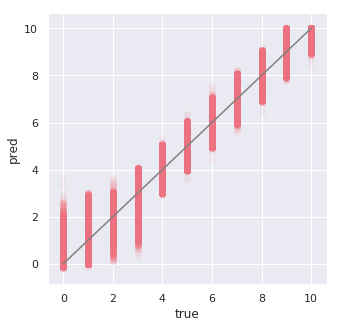

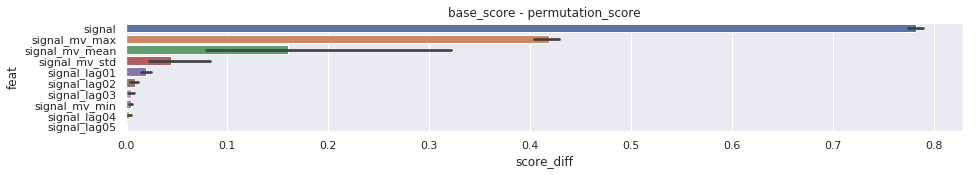

CPU times: user 22min 26s, sys: 2.62 s, total: 22min 28s
Wall time: 5min 5s


In [14]:
%%time
test_pred_round, test_pred, oof_round, oof = train_lgbm(X, y, X_te, lgbm_params,
                                                        n_fold=N_FOLD, 
                                                        verbose=VERBOSE, 
                                                        random_state=KFOLD_SEED, 
                                                        early_stopping_rounds=EARLY_STOPPING_ROUNDS, 
                                                        show_fig=True
                                                       )

# save

In [15]:
save_path = f'{DIR_OUTPUT}submission_nb{NB}_cv_{f1_macro(y, oof_round):.4f}.csv'
sub = pd.read_csv(PATH_SMPLE_SUB)
sub['open_channels'] = test_pred_round
print(f'save path: {save_path}')

save path: ./../data/output/submission_nb007_cv_0.9306.csv


In [22]:
sub.to_csv(save_path, index=False, float_format='%.4f')